In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

df_all = pd.read_csv(Path("./data/train.csv"))
df_sub = pd.read_csv(Path("./data/test.csv"))
df_all.head(2)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_sub.head(2)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_all, y_all = df_all.iloc[:, 1:], df_all.iloc[:, 0]
X_all.head(2)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_all.head(2)


0    1
1    0
Name: label, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torchvision

seed = 42
torch.manual_seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=seed)
t_y_train, t_y_test = torch.from_numpy(y_train.values), torch.from_numpy(y_test.values)
pipe = Pipeline(
    [
        ("scale", FunctionTransformer(func=lambda x: x.values / 255, inverse_func=lambda x: x * 255)),
        ("to_torch", FunctionTransformer(func=lambda x: torch.from_numpy(x))),
        ("reshape", FunctionTransformer(func=lambda x: x.view(-1, 1, 28, 28))),
    ]
)

t_X_train = pipe.transform(X_train)
t_X_test = pipe.transform(X_test)

train_ds = TensorDataset(t_X_train, t_y_train)
valid_ds = TensorDataset(t_X_test, t_y_test)


transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.GaussianBlur(kernel_size=3),
        torchvision.transforms.RandomRotation(20),
    ]
)


class TransformDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        rv = super().__getitem__(index)
        return transforms(rv)


train_dl = TransformDataLoader(train_ds, batch_size=1024 * 6, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=1024 * 6, shuffle=True)

In [15]:
from collections import OrderedDict


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            OrderedDict(
                # (w - ks + 2pad) / s + 1
                [
                    ("conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)),
                    ("bn1", nn.BatchNorm2d(num_features=32)),
                    ("do1", nn.Dropout(p=0.2)),
                    ("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
                    ("bn2", nn.BatchNorm2d(num_features=64)),
                    ("do2", nn.Dropout(p=0.2)),
                    ("conv3", nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)),
                    ("bn3", nn.BatchNorm2d(num_features=32)),
                    ("do3", nn.Dropout(p=0.2)),
                    ("conv4", nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)),
                    ("bn4", nn.BatchNorm2d(num_features=1)),
                    ("do4", nn.Dropout(p=0.2)),
                    ("flatten", nn.Flatten()),
                    ("fc", nn.Linear(in_features=28 * 28, out_features=10)),
                    ("sm", nn.Softmax()),
                ]
            )
        )

    def forward(self, x):
        return self.nn(x)

In [16]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

acc_train, loss_train, acc_valid, loss_valid = [], [], [], []


def update_learning_curve(acc: float, loss: float, is_train: bool):
    if is_train:
        acc_train.append(acc)
        loss_train.append(loss)
    else:
        acc_valid.append(acc)
        loss_valid.append(loss)
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    clear_output(wait=True)
    ax[0].plot(range(1, len(loss_train) + 1), loss_train, label="train")
    ax[0].plot(range(1, len(loss_valid) + 1), loss_valid, label="validation")
    ax[0].set_title("Loss")
    ax[0].set_ylabel("loss")
    ax[1].plot(range(1, len(acc_train) + 1), acc_train, label="train")
    ax[1].plot(range(1, len(acc_valid) + 1), acc_valid, label="validation")
    ax[1].set_title("Accuracy")
    ax[1].set_title("accuracy")
    for i in (0, 1):
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlabel("epoch")
    plt.show()

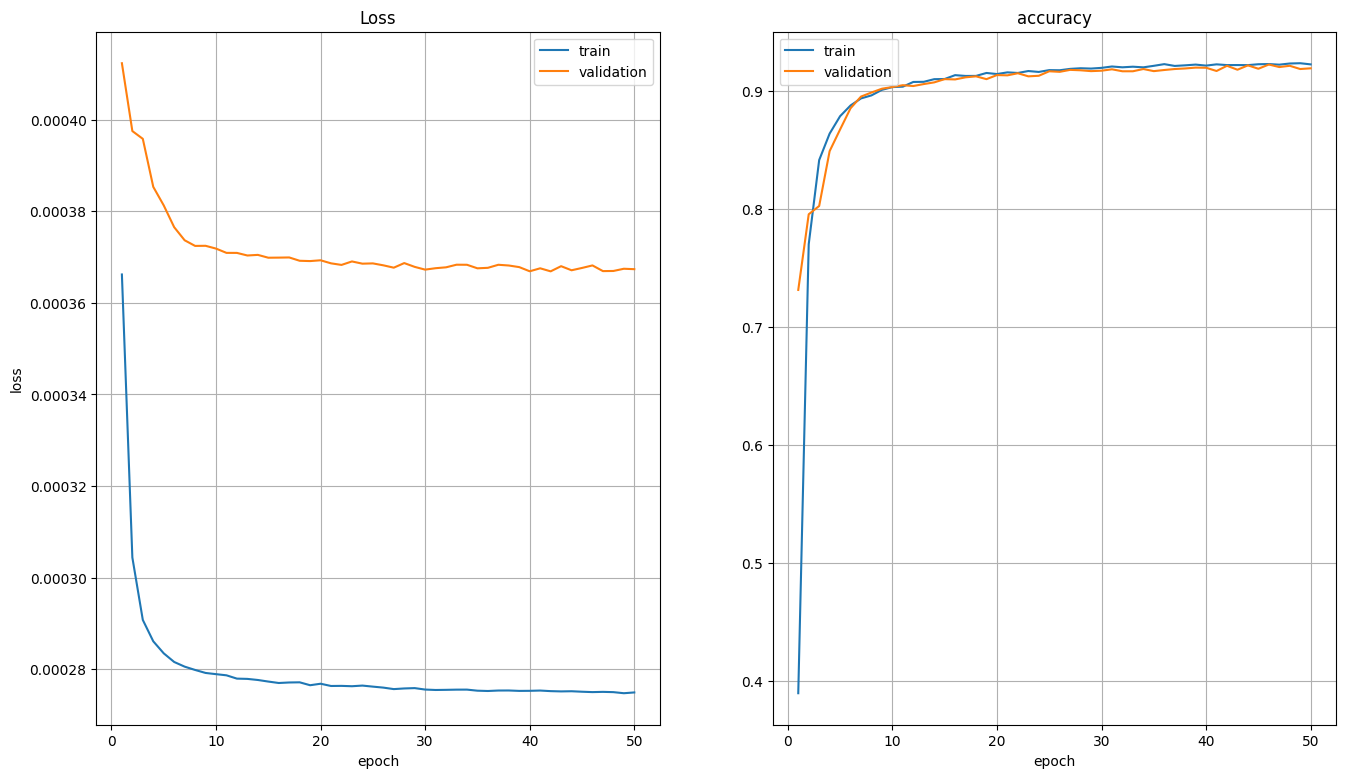

In [17]:
from torch.optim.lr_scheduler import StepLR

model = Net()
cirterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 50


acc_train, loss_train, acc_valid, loss_valid = [], [], [], []
for epoch in range(1, num_epochs + 1):
    model.train()
    model.cuda()
    train_correct, train_loss = 0, 0
    for i, (x, y) in enumerate(train_dl):
        x, y = x.cuda().float(), y.cuda().long()
        optimizer.zero_grad()
        pred = model(x)
        loss = cirterion(pred, y)
        loss.backward()
        optimizer.step()
        pred = torch.argmax(pred, dim=1).detach()
        train_correct += (pred == y).sum().item()
        train_loss += loss.item()
    train_correct /= len(train_ds)
    train_loss /= len(train_ds)
    update_learning_curve(acc=train_correct, loss=train_loss, is_train=True)

    # validate
    valid_correct, valid_loss = 0, 0
    with torch.no_grad():
        model.eval()
        for i, (x, y) in enumerate(valid_dl):
            x, y = x.cuda().float(), y.cuda().long()
            pred = model(x)
            loss = cirterion(pred, y)
            pred = torch.argmax(pred, dim=1).detach()
            valid_correct += (pred == y).sum().item()
            valid_loss += loss.item()
        valid_correct /= len(valid_ds)
        valid_loss /= len(valid_ds)
    update_learning_curve(acc=valid_correct, loss=valid_loss, is_train=False)


In [37]:
model.eval()
with torch.no_grad():
    pred = torch.argmax(model(pipe.transform(df_sub).float().cuda()), dim=-1)
pred

/home/user/.cache/pypoetry/virtualenvs/kaggle-competitions-qoUre2xh-py3.11/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [45]:
sample_df = pd.read_csv('data/sample_submission.csv', index_col=0)
sample_df['Label'] = pred.to('cpu').numpy()
sample_df.to_csv('data/submission.csv')